<a href="https://colab.research.google.com/github/hectormelo/Machine-Learning-Techniques/blob/main/Lab_1/Sesi%C3%B3n%202/Pr%C3%A1ctica_2.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" />
</a>

<img src="https://bloqueneon.uniandes.edu.co/content/enforced/248650-202410_ISIS4219_01/Laboratorios.png" />
<br/>

# Machine Learning Techniques - ISIS4219

Primer semestre - 2024

## Objetivos

- Identificar las diferentes técnicas de pre-procesamiento de datos.
- Construir Pipelines para el procesamiento y entrenamiento del modelo.
- Visualizar un modelo construido en producción.

## Problema

Un supermercado ha decidido clasificar a sus clientes según su puntaje de consumo. Para ello, ha obtenido la información demográfica de varios de sus clientes y le ha pedido a sus expertos que clasifiquen el cliente según su historial de compras y la información recolectada. Luego de un consenso con los directivos del supermercado, se ha decidido clasificar estos clientes en tres diferentes grupos (*Low*, *Average*,  *High*). <br> <br>
Luego de etiquetar estos datos, la gerencia le ha pedido que entrene un modelo de clasificación de sus clientes nuevos, teniendo en cuenta solo la información demográfica del cliente, con el fin de poder agrupar sus clientes y enviar las promociones construidas para ellos.

### **1. Importando las librerias requeridas para el desarrollo del laboratorio**


Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:


**Nota:** Para asegurarse de tener las últimas versiones y todos los paquetes instalados que por lo general no vienen en Google Colab. pueden ejecutar la sigiuente celda.

In [1]:
%pip install pandas ydata-profiling scikit-learn sklearn_features matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Data management Libraries
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

# Data Modeling Libraries
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, MaxAbsScaler, LabelEncoder

# Data visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Save the model
from joblib import dump, load

/run/user/1000/ipykernel_63929/3569025456.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### **2. Perfilamiento y entendimiento de los datos**

#### **Lectura de los Datos**
Primero, se leen los datos y se visualizan que se hayan leído correctamente.

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Lab_1/Sesi%C3%B3n%202/Train.csv')

data.head()

,Unnamed: 0,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0
1,1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0
2,2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
4,4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0


#### **Entendimiento de los Datos**

Luego, vamos a obtener una vista rápida de los datos, para eso utilizaremos la herramienta PandasProfiling.

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

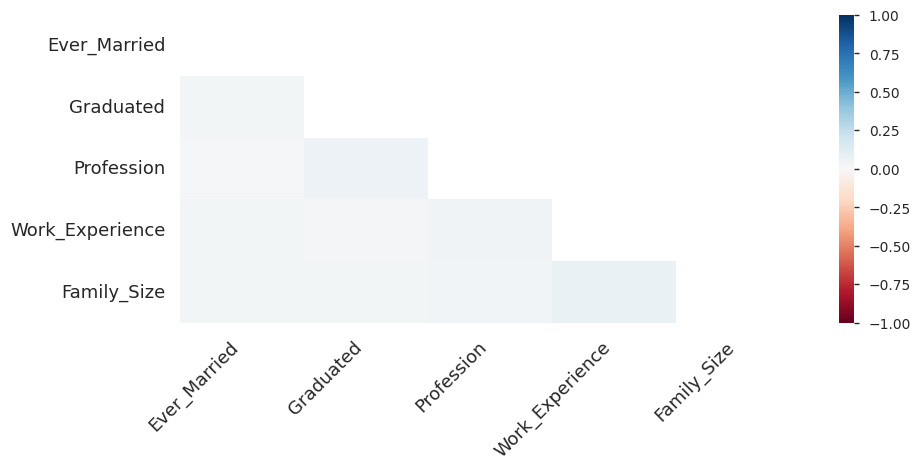

In [4]:
ProfileReport(data)

Además, vamos a realizar visualizaciones individuales de variables de interés.

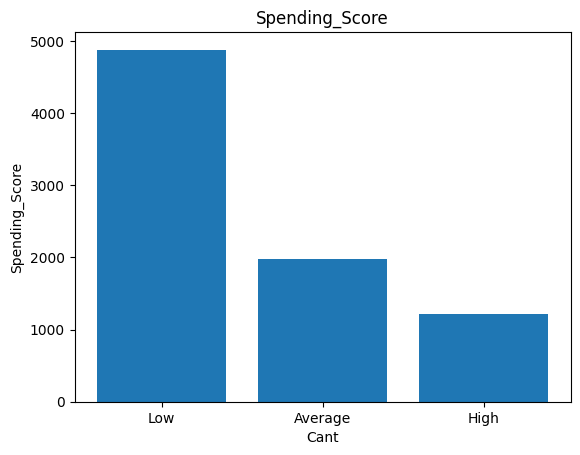

In [5]:
plt.bar(data['Spending_Score'].unique(),data['Spending_Score'].value_counts())
plt.title('Spending_Score')
plt.xlabel('Cant')
plt.ylabel('Spending_Score')
plt.show()

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1000x500 with 0 Axes>

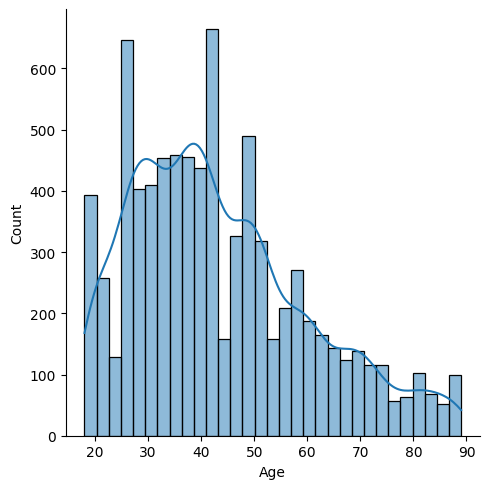

In [6]:
plt.figure(figsize=(10,5))
plt.tight_layout()
sns.displot(data['Age'], kde=True)

### **3. Preparación de Datos**

#### **Separación de Datos**

Como se ve en la sección Entendimiento de los Datos, hay dos variables que realmente no nos están aportando información al problema, como lo son $Unnamed: 0$ y $ID$. <br>
Además por el contexto del problema, nuestra idea será predecir el grupo al cual pertenecerá una nueva persona.

In [7]:
X = data.drop(['Unnamed: 0','ID','Spending_Score'],axis=1)
Y = data['Spending_Score']
X.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Family_Size
0,Male,No,22,No,Healthcare,1.0,4.0
1,Female,Yes,38,Yes,Engineer,NaN,3.0
2,Female,Yes,67,Yes,Engineer,1.0,1.0
3,Male,Yes,67,Yes,Lawyer,0.0,2.0
4,Female,Yes,40,Yes,Entertainment,NaN,6.0


Así mismo, dado que nuestro algoritmo solo entiende números, se va a transformar nuestra variable categórica a una columna de números.

In [8]:
le = LabelEncoder()

le.fit(Y)

Y = le.transform(Y)
print(le.classes_)
Y

['Average' 'High' 'Low']


array([2, 0, 2, ..., 2, 2, 0])

#### **Transformación de Datos**

Debido a que la transformación de datos puede significar la construcción de varios pasos, como el manejo de faltantes, la normalización de datos, la transformación de variables categóricas, entre otros. Se pone en práctica el uso de [Pipeline](https://scikit-learn.org/stable/modules/compose.html), el cual es una herramienta de Sklearn que nos permite unir todos estos procesos y realizar de forma automática todas las transformaciones que necesitemos.

In [9]:
estimators = [('imputer', SimpleImputer(strategy='most_frequent')),
              ('encoder', OrdinalEncoder()),
              ]
pipe = Pipeline(estimators)
pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder())])

In [10]:
X_mod = pipe.fit_transform(X)
data_mod = pd.DataFrame(X_mod,columns=X.columns)
data_mod.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Family_Size
0,1.0,0.0,4.0,0.0,5.0,1.0,3.0
1,0.0,1.0,18.0,1.0,2.0,1.0,2.0
2,0.0,1.0,44.0,1.0,2.0,1.0,0.0
3,1.0,1.0,44.0,1.0,7.0,0.0,1.0
4,0.0,1.0,20.0,1.0,3.0,1.0,5.0


In [11]:
estimators = [('imputer', SimpleImputer(strategy='most_frequent')),
              ('encoder', OrdinalEncoder()),
              ('normalize',MinMaxScaler()),
              ]
pipe2 = Pipeline(estimators)
pipe2

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder()), ('normalize', MinMaxScaler())])

In [12]:
X_mod = pipe2.fit_transform(X)
data_mod = pd.DataFrame(X_mod,columns=X.columns)
data_mod.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Family_Size
0,1.0,0.0,0.060606,0.0,0.625,0.071429,0.375
1,0.0,1.0,0.272727,1.0,0.250,0.071429,0.250
2,0.0,1.0,0.666667,1.0,0.250,0.071429,0.000
3,1.0,1.0,0.666667,1.0,0.875,0.000000,0.125
4,0.0,1.0,0.303030,1.0,0.375,0.071429,0.625




### **4. Modelamiento**

Los Pipelines no solo sirven para construir los datos, transformarlos y adaptarlos. También sirven para conectar un modelo de aprendizaje, ya sea para predecir, clasificar o estimar.

In [13]:
estimators = [('preprocessing', pipe),
              ('clf',LogisticRegression(solver='liblinear')),
              ]
model = Pipeline(estimators)
model

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('encoder', OrdinalEncoder())])),
                ('clf', LogisticRegression(solver='liblinear'))])

In [14]:
model.fit(X,Y)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('encoder', OrdinalEncoder())])),
                ('clf', LogisticRegression(solver='liblinear'))])

Se construye un segundo Pipeline para poder comparar rendimientos.

In [15]:
estimators = [('preprocessing', pipe2),
              ('clf', LogisticRegression(solver='liblinear')),
              ]
model2 = Pipeline(estimators)
model2

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('encoder', OrdinalEncoder()),
                                 ('normalize', MinMaxScaler())])),
                ('clf', LogisticRegression(solver='liblinear'))])

In [16]:
model2.fit(X,Y)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('encoder', OrdinalEncoder()),
                                 ('normalize', MinMaxScaler())])),
                ('clf', LogisticRegression(solver='liblinear'))])

### **5. Predicción**

#### **Predicción del clasificador**

Al igual que en la sección Transformación de Datos, el conjunto de entrada de nuestro modelo serán los datos originales. Pero ahora al incluir un clasificador, el retornará la clase a la cual está prediciendo el dato.

In [17]:
pred1 = model.predict(X)
display(pred1)
pred2 = model2.predict(X)
display(pred2)

array([2, 0, 2, ..., 2, 2, 0])

array([2, 0, 2, ..., 2, 2, 0])

Al obtener un modelo de clasificación y dado nuestras predicciones, podemos construir una matriz de confusión para nuestros modelos.

La documentación de la función la encuentran en la [página de Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

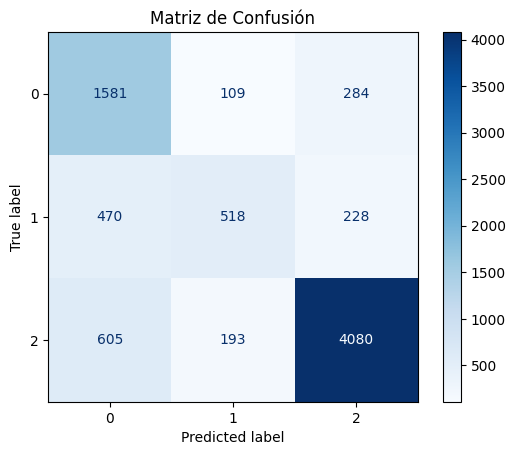

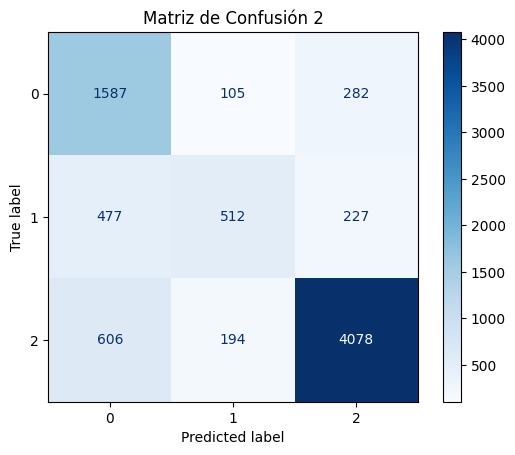

In [18]:
conf_matrix = confusion_matrix(Y, pred1)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap='Blues', values_format='d')

# Añade etiquetas y muestra el gráfico
plt.title('Matriz de Confusión')
plt.show()

conf_matrix2 = confusion_matrix(Y, pred2)
disp = ConfusionMatrixDisplay(conf_matrix2)
disp.plot(cmap='Blues', values_format='d')

# Añade etiquetas y muestra el gráfico
plt.title('Matriz de Confusión 2')
plt.show()

Y por último, para comparar nuestros modelos, utilizaremos un reporte el cual nos muestra la precisión, la cobertura, y la métrica `F1` de las predicciones de ambos modelos.

In [19]:
print('----------Reporte para el Modelo 1----------')
print(classification_report(Y,pred1,target_names=le.classes_))
print('----------Reporte para el Modelo 2----------')
print(classification_report(Y,pred2,target_names=le.classes_))

----------Reporte para el Modelo 1----------
              precision    recall  f1-score   support

     Average       0.60      0.80      0.68      1974
        High       0.63      0.43      0.51      1216
         Low       0.89      0.84      0.86      4878

    accuracy                           0.77      8068
   macro avg       0.71      0.69      0.68      8068
weighted avg       0.78      0.77      0.76      8068

----------Reporte para el Modelo 2----------
              precision    recall  f1-score   support

     Average       0.59      0.80      0.68      1974
        High       0.63      0.42      0.51      1216
         Low       0.89      0.84      0.86      4878

    accuracy                           0.77      8068
   macro avg       0.70      0.69      0.68      8068
weighted avg       0.78      0.77      0.76      8068



#### **Selección de Hiperparámetros**

Otra gran ventaja de los Pipeline, es que nos permite seleccionar los hiperparámetros de construcción para obtener nuestro mejor modelo. Esta construcción la realiza a través de [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Y nos permite escoger los hiperparámetros de cada una de nuestras etapas del Pipeline. También podemos escoger si decidimos utilizar un paso o no.

In [20]:
ct = ColumnTransformer([
       ('num', SimpleImputer(strategy='mean'),
       make_column_selector(dtype_include=np.number)),
       ('cat',
       SimpleImputer(strategy='most_frequent'),
       make_column_selector(dtype_include=object))])

estimators = [('imputer', ct),
              ('encoder', OrdinalEncoder()),
              ('normalize',MaxAbsScaler()),
              ('clf', LogisticRegression(solver='liblinear')),
              ]
pipe = Pipeline(estimators)

param_grid = dict(imputer__num__strategy=['mean', 'median'],
                  imputer__cat__strategy=['most_frequent', 'constant'],
                  encoder=[OrdinalEncoder(), OneHotEncoder()],
                  normalize=['passthrough', MaxAbsScaler()])

grid_search = GridSearchCV(pipe, param_grid=param_grid,cv=5,verbose=3,scoring='accuracy')

grid_search.fit(X,Y.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END encoder=OrdinalEncoder(), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough;, score=0.758 total time=   0.1s
[CV 2/5] END encoder=OrdinalEncoder(), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough;, score=0.747 total time=   0.1s
[CV 3/5] END encoder=OrdinalEncoder(), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough;, score=0.758 total time=   0.1s
[CV 4/5] END encoder=OrdinalEncoder(), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough;, score=0.743 total time=   0.1s
[CV 5/5] END encoder=OrdinalEncoder(), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough;, score=0.764 total time=   0.1s
[CV 1/5] END encoder=OrdinalEncoder(), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=MaxAbsScaler();, s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f80a20d3650>),
                                                                        ('cat',
                                                                         SimpleImputer(strategy='most_frequent'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f80a2f6b710>)])),
                                       ('encoder', OrdinalEncoder()),
                                       ('normalize', MaxAbsScaler()),
                                       ('clf',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'encoder': [OrdinalEncoder(), OneHotEncoder()],
                         'imputer__cat__strategy': ['most_frequent',
                                                    'constant'],
                         'imputer__num__strategy': ['mean', 'median'],
                         'normalize': ['passthrough', MaxAbsScaler()]},
             scoring='accuracy', verbose=3)

Ya que nuestro GridSearch entrenó todos los modelos, ahora podemos visualizar cuales fueron nuestros mejores hiperparámetros seleccionados, nuestro mejor modelo y una tabla de resultados de todos los modelos evaluados.

In [21]:
print(grid_search.best_params_)

{'encoder': OneHotEncoder(), 'imputer__cat__strategy': 'most_frequent', 'imputer__num__strategy': 'mean', 'normalize': 'passthrough'}


In [22]:
resultados = pd.DataFrame(grid_search.cv_results_)
display(resultados)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_encoder,param_imputer__cat__strategy,param_imputer__num__strategy,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.070481,0.004565,0.006496,0.000726,OrdinalEncoder(),most_frequent,mean,passthrough,"{'encoder': OrdinalEncoder(), 'imputer__cat__s...",0.757745,0.746592,0.758364,0.743335,0.764414,0.754090,0.007875,11
1,0.045738,0.001700,0.006415,0.000522,OrdinalEncoder(),most_frequent,mean,MaxAbsScaler(),"{'encoder': OrdinalEncoder(), 'imputer__cat__s...",0.758364,0.747212,0.757745,0.741476,0.760694,0.753098,0.007440,12
2,0.067701,0.001398,0.006187,0.000299,OrdinalEncoder(),most_frequent,median,passthrough,"{'encoder': OrdinalEncoder(), 'imputer__cat__s...",0.764560,0.752788,0.766419,0.748915,0.777433,0.762023,0.010201,9
3,0.050456,0.003711,0.006716,0.000398,OrdinalEncoder(),most_frequent,median,MaxAbsScaler(),"{'encoder': OrdinalEncoder(), 'imputer__cat__s...",0.765799,0.752788,0.766419,0.742715,0.776813,0.760907,0.011867,10
4,0.057389,0.002482,0.006105,0.000423,OrdinalEncoder(),constant,mean,passthrough,"{'encoder': OrdinalEncoder(), 'imputer__cat__s...",0.744734,0.733581,0.741636,0.725976,0.748915,0.738968,0.008211,15
5,0.041846,0.003570,0.007313,0.001305,OrdinalEncoder(),constant,mean,MaxAbsScaler(),"{'encoder': OrdinalEncoder(), 'imputer__cat__s...",0.742255,0.732342,0.741636,0.723497,0.745195,0.736985,0.008004,16
6,0.059681,0.003636,0.006292,0.000615,OrdinalEncoder(),constant,median,passthrough,"{'encoder': OrdinalEncoder(), 'imputer__cat__s...",0.750929,0.732962,0.749071,0.731556,0.756355,0.744174,0.010029,13
7,0.046629,0.008016,0.007893,0.002622,OrdinalEncoder(),constant,median,MaxAbsScaler(),"{'encoder': OrdinalEncoder(), 'imputer__cat__s...",0.749690,0.732962,0.746592,0.727216,0.750155,0.741323,0.009431,14
8,0.058300,0.002734,0.006494,0.000485,OneHotEncoder(),most_frequent,mean,passthrough,"{'encoder': OneHotEncoder(), 'imputer__cat__st...",0.802974,0.800496,0.815985,0.802232,0.819591,0.808255,0.007907,1
9,0.056520,0.001334,0.006556,0.000162,OneHotEncoder(),most_frequent,mean,MaxAbsScaler(),"{'encoder': OneHotEncoder(), 'imputer__cat__st...",0.802974,0.800496,0.815985,0.802232,0.819591,0.808255,0.007907,1


Y por último, guardaremos nuestro modelo para utilizarlo después.

In [23]:
dump(grid_search.best_estimator_, 'my_model.joblib')

model = load('my_model.joblib')

pred1 = model.predict(X)
print('----------Reporte para el Mejor Modelo----------')
print(classification_report(Y,pred1,target_names=le.classes_))

----------Reporte para el Mejor Modelo----------
              precision    recall  f1-score   support

     Average       0.63      0.90      0.74      1974
        High       0.74      0.62      0.68      1216
         Low       0.96      0.83      0.89      4878

    accuracy                           0.82      8068
   macro avg       0.78      0.78      0.77      8068
weighted avg       0.84      0.82      0.82      8068



### **6. Validación**

Para la validación, utilizaremos un nuevo conjunto de datos que nos servirán como Conjunto Test. Como se han dado cuenta, en ningún momento le he pasado estos nuevos datos durante la etepa de entrenamiento.

In [24]:
test = pd.read_csv('https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Lab_1/Sesi%C3%B3n%202/Test.csv')
X_test = test.drop(['Unnamed: 0','ID','Spending_Score'],axis=1)
Y_test = le.transform(test['Spending_Score'])

In [25]:
y_pred=model.predict(X_test)

print('----------Reporte para el Mejor Modelo con datos nuevos----------')
print(classification_report(Y_test,y_pred,target_names=le.classes_))

----------Reporte para el Mejor Modelo con datos nuevos----------
              precision    recall  f1-score   support

     Average       0.62      0.89      0.73       625
        High       0.72      0.62      0.67       386
         Low       0.95      0.83      0.88      1616

    accuracy                           0.81      2627
   macro avg       0.77      0.78      0.76      2627
weighted avg       0.84      0.81      0.82      2627



Y ahora, se construye un dato propio para ver como se comporta nuestro modelo.

In [26]:
Gender = 'Female'
Ever_Married = 'Yes'
Age = 36
Graduated = 'Yes'
Profession = np.nan
Work_Experience = 0
Family_Size = 3
row = [Gender, Ever_Married, Age, Graduated, Profession, Work_Experience, Family_Size]

input = pd.DataFrame([row],columns=X.columns)

resp = model.predict(input)

print(model.predict_proba(input))

le.inverse_transform(resp)[0]

[[0.69783857 0.10162467 0.20053677]]


'Average'

Para desarrollar:

- Para este caso, solo se establecieron como hiperparámetros, el preprocesamiento de los datos, ¿Cuáles serían los hiperparámetros de la Regresión Logística? ¿Cual sería el mejor modelo que se podría construir?
- Los expertos del supermercado le han sugerido utilizar el algoritmo [KNN-Clasifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), ¿Se obtuvo un mejor modelo?
- Se dieron cuenta que sus clientes más representativos son aquellos que están clasificados en la clase 'High', por eso quieren identificar a todos sus clientes potenciales para ofrecerles descuentos. Pueden aceptar que algún cliente que no esté en esta categoría reciba la oferta, pero es importante que todos los clientes (o su gran mayoría) sea capaz de recibir esta oferta. ¿Cual sería el mejor modelo para este caso?